In [166]:
# imports

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout,Input
import random
import numpy as np
import pandas as pd
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from collections import Counter
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from scipy.ndimage import uniform_filter
from sklearn.decomposition import PCA
from IPython.display import Markdown, display, JSON
from keras import backend as K

# **3. Load the mnist dataset**
***

In [167]:
# define random seed
seed=42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

# Load and prepare the MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0  # Normalize pixel values

# **4. Present simple statistics of this dataset:**
***

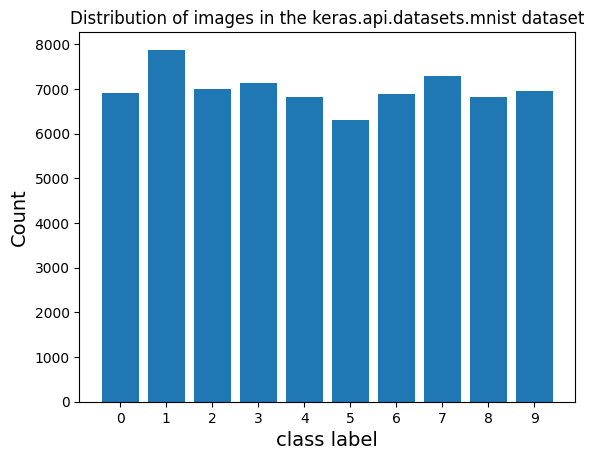

,Class distribution,Average number of white pixels,Standard deviation of white pixels,number of common non-white pixels
Digit,,,,
0,6903.0,7.240910,24.266312,345.0
1,7877.0,3.613685,10.816985,490.0
2,6990.0,5.944492,20.322924,300.0
3,7141.0,5.953368,20.555728,326.0
4,6824.0,4.847743,16.463461,316.0
5,6313.0,5.359575,18.257221,310.0
6,6876.0,5.504945,18.786060,356.0
7,7293.0,4.539284,15.439864,332.0
8,6825.0,5.555458,19.388457,350.0


In [168]:
def show_statistics(dataset):
    """
    Shows some statistics about the dataset
    :param dataset: 
    :return: 
    """
    # load the dataset
    (input_train, labels_train),(input_test,labels_test) = dataset.load_data()
     
     # combine training and test
    images = np.concatenate((input_train, input_test), axis=0)
    labels = np.concatenate((labels_train, labels_test), axis=0)
    
    
    # show the distribution of the images
    class_distribution = np.bincount(labels)
    indices = np.arange(class_distribution.size)
    plt.title(f'Distribution of images in the {dataset.__name__} dataset')
    plt.xlabel('class label', fontsize=14)
    plt.ylabel('Count', fontsize=14)
    plt.xticks(indices,labels=indices)
    plt.bar(indices,class_distribution)
    plt.show()
    
    # average number of white pixels(255) and their std per class
    average_white_pixels = []
    std_white_pixels = []
    common_non_white_pixels = []
    
    for digit in range(10): # 10 digits 0-9:
        digit_images = images[labels == digit]
        
        # columns of pixels, with consideration to RGB matrix
        white_pixels_count = np.sum(digit_images == 255, axis=(1, 2)) 
        average_white_pixels.append(np.mean(white_pixels_count))
        std_white_pixels.append(np.std(white_pixels_count))
        
        #calculate common non-white pixels- if any pixel is not 255, it is not white. 
        # sum all the areas of that along the images
        common_non_white = np.all(digit_images!= 255, axis =0).sum()     
        common_non_white_pixels.append(common_non_white)
        
    # Compile results
    statistics = {
        "Class distribution": class_distribution,
        "Average number of white pixels": average_white_pixels,
        "Standard deviation of white pixels": std_white_pixels,
        "number of common non-white pixels": common_non_white_pixels,
    }
    
    df_statistics = pd.DataFrame(statistics)
    summary_row = [np.sum(class_distribution), np.mean(average_white_pixels), np.mean(std_white_pixels), np.mean(common_non_white_pixels)]
    
    df_statistics.rename_axis('Digit', inplace=True)
    df_statistics.loc["Total Summary"] = summary_row
    display(df_statistics)
    
  
show_statistics(mnist)

**Note:** The total summary row contains the following:
* A summation of the class distribution along all classes (i.e. the total number of images in the dataset)
* An average of the average number of white pixels in each class (i.e. the average number of white pixels among all digits)
* The average standard deviation of white pixels among all digits
* The average number of common non-white pixels among all digits

# **5.Apply a simple neural network**
***


In [169]:
def multi_class_specificity(y_true, y_pred,num_classes):
    cm = confusion_matrix(y_true, y_pred)
    specificity = []
    for i in range(num_classes):
        tn = np.sum(cm) - (np.sum(cm[i, :]) + np.sum(cm[:, i]) - cm[i, i])
        fp = np.sum(cm[:, i]) - cm[i, i]
        specificity.append(tn / (tn + fp))
    return specificity

In [170]:
def create_classification_report(y_true,y_pred):
    # Evaluate the model on test data
    results = classification_report(y_true, y_pred, output_dict=True)
    not_class_specific_headers = ["accuracy","macro avg", "weighted avg"]
    class_specific_results = {key: value for key, value in results.items() if not key in not_class_specific_headers}
    
    for i in range(10):
        class_specific_results[str(i)].update({"specificity": multi_class_specificity(y_true, y_pred,10)[i]})
        
    general_results = {key: value for key, value in results.items() if  key in not_class_specific_headers}
    general_results['macro avg'].update({"specificity":np.mean([class_specific_results[str(i)]["specificity"] for i in range(10)])})
    
    # weighted average 
    weights = np.bincount(y_test) / len(y_true) 
    general_results['weighted avg'].update({"specificity": np.sum([weights[i] * class_specific_results[str(i)]["specificity"] for i in range(10)])})
    display(Markdown("## **Accuracy**\n***"))
    display(Markdown(f"##### **Accuracy: {results['accuracy']}**"))
    display(Markdown("## **Class-specific results**\n***"))
    display(pd.DataFrame(class_specific_results))
    display(Markdown("## **Averaging results**\n***"))
    display(pd.DataFrame({key: value for key, value in general_results.items() if key != 'accuracy'}).transpose())

In [175]:
# Build the neural network model
model = Sequential([
    Input(shape=(28, 28)),  # Input layer specifying the shape of input data
    Flatten(),  # Flatten the 28x28 images to a 1D array
    Dense(128, activation='relu'),  # Fully connected layer with 128 units and ReLU activation
    Dropout(0.2),  # Dropout layer to prevent overfitting
    Dense(10)  # Output layer with 10 units (one for each digit class)
])

# Compile the model with the desired metrics
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Train the model
model.fit(x_train, y_train, epochs=5)

# assign the class with the highest prediction score to each image
y_pred = tf.argmax(model.predict(x_test), axis=1)   

create_classification_report(y_test,y_pred)

Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.8588 - loss: 0.4815
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9542 - loss: 0.1529
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9678 - loss: 0.1072
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9729 - loss: 0.0883
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9768 - loss: 0.0741
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 887us/step


## **Accuracy**
***

##### **Accuracy: 0.9774**

## **Class-specific results**
***

,0,1,2,3,4,5,6,7,8,9
precision,0.987730,0.992933,0.973863,0.971429,0.983488,0.977452,0.979275,0.968177,0.968303,0.970179
recall,0.985714,0.990308,0.974806,0.976238,0.970468,0.971973,0.986430,0.976654,0.972279,0.967294
f1-score,0.986721,0.991619,0.974334,0.973827,0.976935,0.974705,0.982839,0.972397,0.970287,0.968734
support,980.000000,1135.000000,1032.000000,1010.000000,982.000000,892.000000,958.000000,1028.000000,974.000000,1009.000000
specificity,0.998670,0.999098,0.996989,0.996774,0.998226,0.997804,0.997788,0.996322,0.996565,0.996663


## **Averaging results**
***

,precision,recall,f1-score,support,specificity
macro avg,0.977283,0.977217,0.977240,10000.0,0.997490
weighted avg,0.977426,0.977400,0.977404,10000.0,0.997499


For each class we calculated the following metrics:
* precision
* recall(sensitivity)
* f1-score
* support (number of samples in each class)
* specificity

It can be seen that the model performed excellently in all measures: it gained 97% accuracy, precision recall and f1-score, and 99% specificity on the test set. This can either imply overfitting or it could be that the mnist dataset is just too good to be true :)

# **6.confusion matrix**
***

In [178]:
def create_and_plot_confusion_matrix(y_true,y_pred):
    # Generate the confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    print(cm)
    
    # Define labels for the confusion matrix
    labels = [str(i) for i in range(10)]
    
    # Visualize the confusion matrix using seaborn
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

[[ 966    0    3    1    0    2    5    2    1    0]
 [   0 1124    3    1    0    1    2    1    3    0]
 [   2    0 1006    1    3    0    2    9    9    0]
 [   0    0    4  986    0    6    0    7    3    4]
 [   0    0    6    0  953    0    3    2    2   16]
 [   2    0    0    8    1  867    5    0    5    4]
 [   3    2    0    1    2    3  945    0    2    0]
 [   2    2    9    4    0    0    0 1004    2    5]
 [   2    0    2    6    2    7    2    5  947    1]
 [   1    4    0    7    8    1    1    7    4  976]]


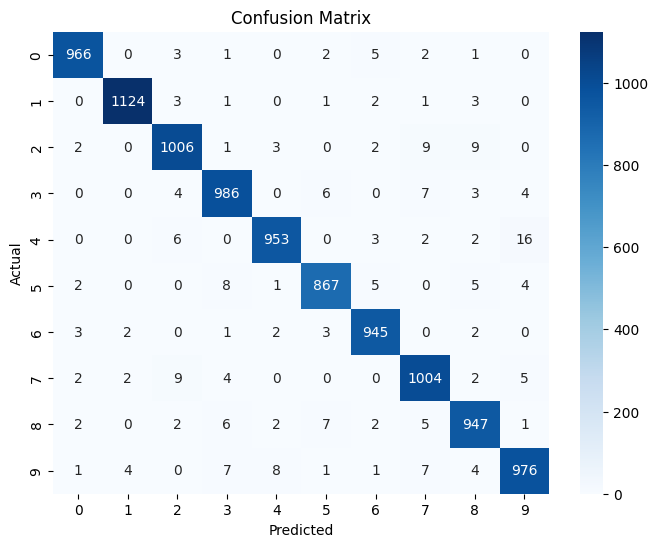

In [179]:
create_and_plot_confusion_matrix(y_test,y_pred)

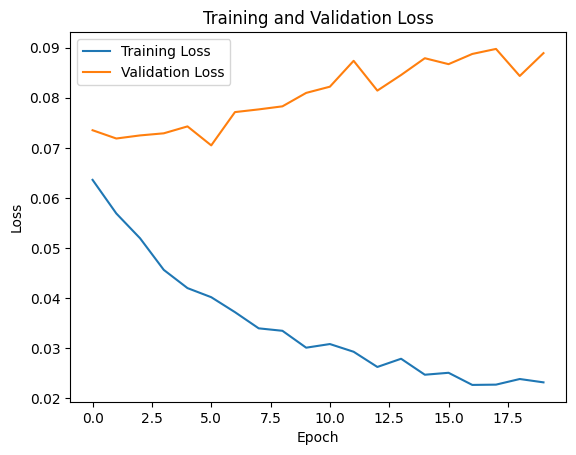

Optimal number of epochs: 6


In [180]:

# Train the model and record history
history = model.fit(x_train, y_train, epochs=20, validation_data=(x_test, y_test), verbose=0)

# Plot training loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Find the epoch with the minimum validation loss
min_val_loss_epoch = np.argmin(history.history['val_loss']) + 1
print(f"Optimal number of epochs: {min_val_loss_epoch}")

# **Step 8: Construct a New Dataset with Averaged Pixels**
***

In [174]:
def average_surrounding_pixels(images):
    return np.array([uniform_filter(image, size=2) for image in images])

X_train_avg = average_surrounding_pixels(x_train)
X_test_avg = average_surrounding_pixels(x_test)

KeyboardInterrupt: 

In [ ]:
# Build the neural network model
AVG_model = Sequential([
    Input(shape=(28, 28)),  # Input layer specifying the shape of input data
    Flatten(),  # Flatten the 28x28 images to a 1D array
    Dense(128, activation='relu'),  # Fully connected layer with 128 units and ReLU activation
    Dropout(0.2),  # Dropout layer to prevent overfitting
    Dense(10)  # Output layer with 10 units (one for each digit class)
])

# Compile the model with the desired metrics
AVG_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Train the model
AVG_history = AVG_model.fit(X_train_avg, y_train, epochs=20, validation_data=(X_test_avg, y_test), verbose=0)
results = AVG_model.evaluate(X_test_avg, y_test, verbose=2)

#classification
y_pred = tf.argmax(AVG_model.predict(X_test_avg), axis=1)

# Evaluate the model on test data

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Calculate Precision, Recall, and F1 Score manually

print("Accuracy score:", accuracy)
print("Precision score:", precision)
print("Recall (Sensitivity) score:", recall)
print("F1 score:", f1)

In [ ]:
# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

# Define labels for the confusion matrix
labels = [str(i) for i in range(10)]

# Visualize the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Print classification report for detailed analysis
print(classification_report(y_test, y_pred, target_names=labels))


In [ ]:

# Plot training loss
plt.plot(AVG_history.history['loss'], label='Training Loss')
plt.plot(AVG_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Find the epoch with the minimum validation loss
min_val_loss_epoch = np.argmin(AVG_history.history['val_loss']) + 1
print(f"Optimal number of epochs: {min_val_loss_epoch}")


# **10a: Dimension Reduction using Principal Component Analysis (PCA)**
***


# **10b: Dimension Reduction by 3x3 Pixel Block Averaging**
***

In [ ]:
# Flatten the images
X_train_flat = x_train.reshape(x_train.shape[0], -1)
X_test_flat = x_test.reshape(x_test.shape[0], -1)

# Define the number of components you want to keep
n_components = 50  # Example number, adjust based on your dataset
pca = PCA(n_components=n_components)

# Fit and transform the training data
X_train_pca = pca.fit_transform(X_train_flat)
X_test_pca = pca.transform(X_test_flat)

In [ ]:
# Restore the reduced dimensionality images back to their original shape
x_train_pca_img = pca.inverse_transform(X_train_pca).reshape(x_train.shape[0], 28, 28)
x_test_pca_img = pca.inverse_transform(X_test_pca).reshape(x_test.shape[0], 28, 28)

# Reshape data to fit the model
x_train_pca_img = x_train_pca_img.reshape(x_train_pca_img.shape[0], 28, 28, 1)
x_test_pca_img = x_test_pca_img.reshape(x_test_pca_img.shape[0], 28, 28, 1)


In [ ]:
# Build the neural network model
PCA_model = Sequential([
    Input(shape=(28, 28)),  # Input layer specifying the shape of input data
    Flatten(),  # Flatten the 28x28 images to a 1D array
    Dense(128, activation='relu'),  # Fully connected layer with 128 units and ReLU activation
    Dropout(0.2),  # Dropout layer to prevent overfitting
    Dense(10)  # Output layer with 10 units (one for each digit class)
])

# Compile the model with the desired metrics
PCA_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Train the model
PCA_history = PCA_model.fit(x_train_pca_img, y_train, epochs=20, validation_data=(x_test_pca_img, y_test), verbose=0)
# Evaluate the model on test data
results = PCA_model.evaluate(x_test_pca_img, y_test, verbose=2)

# Calculate Precision, Recall, and F1 Score manually
y_pred = tf.argmax(PCA_model.predict(x_test_pca_img), axis=1)

# Evaluate the model on test data

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print("Accuracy score:", accuracy)
print("Precision score:", precision)
print("Recall (Sensitivity) score:", recall)
print("F1 score:", f1)

In [ ]:
# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

# Define labels for the confusion matrix
labels = [str(i) for i in range(10)]

# Visualize the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Print classification report for detailed analysis
print(classification_report(y_test, y_pred, target_names=labels))


In [ ]:
# Plot training loss
plt.plot(PCA_history.history['loss'], label='Training Loss')
plt.plot(PCA_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Find the epoch with the minimum validation loss
min_val_loss_epoch = np.argmin(PCA_history.history['val_loss']) + 1
print(f"Optimal number of epochs: {min_val_loss_epoch}")


# **Create Imbalanced Dataset by Undersampling**
***

In [ ]:
# Function to perform undersampling
def undersample(X, y, classes_to_undersample, target_count):
    undersampled_X, undersampled_y = [], []
    class_counts = Counter(y)

    for class_label in np.unique(y):
        class_indices = np.where(y == class_label)[0]
        if class_label in classes_to_undersample:
            sampled_indices = np.random.choice(class_indices, target_count, replace=False)
        else:
            sampled_indices = class_indices

        undersampled_X.append(X[sampled_indices])
        undersampled_y.append(y[sampled_indices])

    return np.vstack(undersampled_X), np.hstack(undersampled_y)

# Select two classes to undersample (e.g., classes 0 and 9)
classes_to_undersample = [0,9]
target_count = 500  # Number of samples for each undersampled class

X_train_undersampled, y_train_undersampled = undersample(x_train, y_train, classes_to_undersample, target_count)



print("Original class distribution:", Counter(y_train))
print("New class distribution after undersampling:", Counter(y_train_undersampled))

In [ ]:
# Build the neural network model
OS_model = Sequential([
    Input(shape=(28, 28)),  # Input layer specifying the shape of input data
    Flatten(),  # Flatten the 28x28 images to a 1D array
    Dense(128, activation='relu'),  # Fully connected layer with 128 units and ReLU activation
    Dropout(0.2),  # Dropout layer to prevent overfitting
    Dense(10)  # Output layer with 10 units (one for each digit class)
])

# Compile the model with the desired metrics
OS_model.compile(optimizer='adam',
                 loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                 metrics=['accuracy'])

# Train the model
OS_history = OS_model.fit(X_train_undersampled, y_train_undersampled, epochs=20, validation_data=(x_test, y_test), verbose=0)
results = OS_model.evaluate(x_test, y_test, verbose=2)

#classification
y_pred = tf.argmax(OS_model.predict(x_test), axis=1)

# Evaluate the model on test data

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Calculate Precision, Recall, and F1 Score manually

print("Accuracy score:", accuracy)
print("Precision score:", precision)
print("Recall (Sensitivity) score:", recall)
print("F1 score:", f1)
# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

# Define labels for the confusion matrix
labels = [str(i) for i in range(10)]

# Visualize the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Print classification report for detailed analysis
print(classification_report(y_test, y_pred, target_names=labels))

# Plot training loss
plt.plot(OS_history.history['loss'], label='Training Loss')
plt.plot(OS_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Find the epoch with the minimum validation loss
min_val_loss_epoch = np.argmin(OS_history.history['val_loss']) + 1
print(f"Optimal number of epochs: {min_val_loss_epoch}")


# **Create Imbalanced Dataset by Oversampling with Image Manipulations**
***

In [ ]:
# Create an image data generator for augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Function to perform oversampling with image augmentations
def oversample_with_augmentation(X, y, classes_to_oversample, target_count):
    oversampled_X, oversampled_y = [], []
    class_counts = Counter(y)

    for class_label in np.unique(y):
        class_indices = np.where(y == class_label)[0]
        class_images = X[class_indices]

        if class_label in classes_to_oversample:
            while len(class_images) < target_count:
                augmented_images = next(datagen.flow(class_images, batch_size=target_count - len(class_images)))
                class_images = np.vstack((class_images, augmented_images))
            class_images = class_images[:target_count]

        oversampled_X.append(class_images)
        oversampled_y.append([class_label] * len(class_images))

    return np.vstack(oversampled_X), np.hstack(oversampled_y)

# Select two classes to oversample (e.g., classes 0 and 1)
classes_to_oversample = [0,9]
target_count = 10000  # Desired number of samples for each oversampled class

X_train_oversampled, y_train_oversampled = oversample_with_augmentation(x_train, y_train, classes_to_oversample, target_count)

print("Original class distribution:", Counter(y_train))
print("New class distribution after oversampling:", Counter(y_train_oversampled))


In [ ]:
# Build the neural network model
OS2_model = Sequential([
    Input(shape=(28, 28)),  # Input layer specifying the shape of input data
    Flatten(),  # Flatten the 28x28 images to a 1D array
    Dense(128, activation='relu'),  # Fully connected layer with 128 units and ReLU activation
    Dropout(0.2),  # Dropout layer to prevent overfitting
    Dense(10)  # Output layer with 10 units (one for each digit class)
])

# Compile the model with the desired metrics
OS2_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Train the model
OS2_history = OS2_model.fit(X_train_oversampled, y_train_oversampled, epochs=20, validation_data=(x_test, y_test), verbose=0)
results = OS2_model.evaluate(x_test, y_test, verbose=2)

#classification
y_pred = tf.argmax(OS2_model.predict(x_test), axis=1)

# Evaluate the model on test data

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Calculate Precision, Recall, and F1 Score manually

print("Accuracy score:", accuracy)
print("Precision score:", precision)
print("Recall (Sensitivity) score:", recall)
print("F1 score:", f1)

In [ ]:
# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

# Define labels for the confusion matrix
labels = [str(i) for i in range(10)]

# Visualize the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Print classification report for detailed analysis
print(classification_report(y_test, y_pred, target_names=labels))

# Plot training loss
plt.plot(OS2_history.history['loss'], label='Training Loss')
plt.plot(OS2_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Find the epoch with the minimum validation loss
min_val_loss_epoch = np.argmin(OS2_history.history['val_loss']) + 1
print(f"Optimal number of epochs: {min_val_loss_epoch}")